#Preprocessing

In [ ]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.5 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd
import re
import nltk
from pyvi import ViTokenizer

In [ ]:
# Read json file
json_data_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/shopee_aonam.json'
with open(json_data_path, encoding='utf-8') as f:
    info = json.load(f)

print('Total products:', len(info))

Total products: 31


In [ ]:
comments = []
product_names = []
product_links = []
comment_counts = []

def is_none_comment(text):
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    if text == '':
        return True
    else:
        return False

for id, product in enumerate(info):
    if 'comments' not in product:
        continue

    product_comment_count = 0

    for comment in product['comments']:
        if is_none_comment(comment['content']):
            continue
        comments.append(comment)
        product_comment_count += 1

    comment_counts.append(product_comment_count)
    product_names.append(product['name'])
    product_links.append(product['link'])

# for i in range(len(product_names)):
#     print(f"Product {i+1} | Number of Comments: {comment_counts[i]}")

print('Total number of comments:', len(comments))

Total number of comments: 684


In [ ]:
# Extract relevant fields
df = pd.DataFrame(comments)
df.drop(['author', 'time', 'seller_respond', 'rating', 'like_count'], axis=1, inplace=True)
df

,content
0,"Form áo, đường may, chất liệu vải, đóng gói, h..."
1,"Áo đẹp lắm nha, nhân viên tư vấn nhiệt tình. G..."
2,Màu sắc: trắng\nChất liệu: cotton\nĐúng với mô...
3,Màu sắc: den\nĐúng với mô tả: ok\nChất liệu: o...
4,"Shop phục vụ tốt lắm ạ, mình đặt nhầm size, nt..."
...,...
679,Bắt chờ 1 tuần mà giao thiếu hàng
680,Áo thủng rách :)) chán thật sự
681,"Form áo của shop này lạ quá, size M thì ngắn c..."
682,Chất liệu: Vải\nĐúng với mô tả: khoonggg\nMàu ...


In [ ]:
'''
Not work well as rating not always describe the sentiment correctly

# Map ratings to sentiment
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df['sentiment'] = df['rating'].apply(map_rating_to_sentiment)
df
'''

'\nNot work well as rating not always describe the sentiment correctly\n\n# Map ratings to sentiment\ndef map_rating_to_sentiment(rating):\n    if rating >= 4:\n        return "positive"\n    elif rating == 3:\n        return "neutral"\n    else:\n        return "negative"\n\ndf[\'sentiment\'] = df[\'rating\'].apply(map_rating_to_sentiment)\ndf\n'

In [ ]:
import string

# Clean text
def clean_text(text):
    # text = re.sub(r'[' + re.escape(string.punctuation) + r']', '', text)  # Remove punctuation characters
    punctuation_to_remove = string.punctuation.replace("!", "").replace("?", "")    # Keep ! and ? punctuation
    text = re.sub(r'[' + re.escape(punctuation_to_remove) + r']', '', text) # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_content'] = df['content'].apply(clean_text)
df

,content,cleaned_content
0,"Form áo, đường may, chất liệu vải, đóng gói, h...",form áo đường may chất liệu vải đóng gói hộp g...
1,"Áo đẹp lắm nha, nhân viên tư vấn nhiệt tình. G...",áo đẹp lắm nha nhân viên tư vấn nhiệt tình gia...
2,Màu sắc: trắng\nChất liệu: cotton\nĐúng với mô...,màu sắc trắng chất liệu cotton đúng với mô tả ...
3,Màu sắc: den\nĐúng với mô tả: ok\nChất liệu: o...,màu sắc den đúng với mô tả ok chất liệu ok đón...
4,"Shop phục vụ tốt lắm ạ, mình đặt nhầm size, nt...",shop phục vụ tốt lắm ạ mình đặt nhầm size nt c...
...,...,...
679,Bắt chờ 1 tuần mà giao thiếu hàng,bắt chờ 1 tuần mà giao thiếu hàng
680,Áo thủng rách :)) chán thật sự,áo thủng rách chán thật sự
681,"Form áo của shop này lạ quá, size M thì ngắn c...",form áo của shop này lạ quá size m thì ngắn củ...
682,Chất liệu: Vải\nĐúng với mô tả: khoonggg\nMàu ...,chất liệu vải đúng với mô tả khoonggg màu sắc ...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

In [ ]:
# Map content to sentiment using pretrained model
def map_content_to_sentiment(content):
    return predict_sentiment([content])[0]

df['sentiment'] = df['cleaned_content'].apply(map_content_to_sentiment)
df

,content,cleaned_content,sentiment
0,"Form áo, đường may, chất liệu vải, đóng gói, h...",form áo đường may chất liệu vải đóng gói hộp g...,Positive
1,"Áo đẹp lắm nha, nhân viên tư vấn nhiệt tình. G...",áo đẹp lắm nha nhân viên tư vấn nhiệt tình gia...,Positive
2,Màu sắc: trắng\nChất liệu: cotton\nĐúng với mô...,màu sắc trắng chất liệu cotton đúng với mô tả ...,Positive
3,Màu sắc: den\nĐúng với mô tả: ok\nChất liệu: o...,màu sắc den đúng với mô tả ok chất liệu ok đón...,Neutral
4,"Shop phục vụ tốt lắm ạ, mình đặt nhầm size, nt...",shop phục vụ tốt lắm ạ mình đặt nhầm size nt c...,Positive
...,...,...,...
679,Bắt chờ 1 tuần mà giao thiếu hàng,bắt chờ 1 tuần mà giao thiếu hàng,Negative
680,Áo thủng rách :)) chán thật sự,áo thủng rách chán thật sự,Negative
681,"Form áo của shop này lạ quá, size M thì ngắn c...",form áo của shop này lạ quá size m thì ngắn củ...,Negative
682,Chất liệu: Vải\nĐúng với mô tả: khoonggg\nMàu ...,chất liệu vải đúng với mô tả khoonggg màu sắc ...,Neutral


In [ ]:
wrong_sentiments = [
    (3, 'Positive'), (7, 'Negative'), (9, 'Drop'), (10, 'Drop'), (11, 'Drop'), (12, 'Drop'), (13, 'Drop'), (14, 'Drop'), (15, 'Drop'), (17, 'Drop'), (18, 'Negative'), (19, 'Negative'), (20, 'Drop'), (23, 'Negative'), (41, 'Drop'), (45, 'Drop'), (48, 'Negative'), (50, 'Negative'), (54, 'Negative'), (58, 'Drop'), (59, 'Positive'), (61, 'Positive'), (62, 'Drop'), (64, 'Drop'), (67, 'Drop'), (70, 'Positive'), (71, 'Drop'), (72, 'Positive'), (73, 'Negative'), (74, 'Negative'), (77, 'Negative'), (78, 'Drop'), (79, 'Drop'), (81, 'Drop'), (85, 'Negative'), (101, 'Negative'), (103, 'Drop'), (107, 'Negative'), (110, 'Neutral'), (112, 'Drop'), (114, 'Negative'), (116, 'Negative'), (117, 'Neutral'), (118, 'Negative'), (119, 'Positive'), (121, 'Positive'), (125, 'Positive'), (134, 'Negative'), (136, 'Negative'), (138, 'Negative'), (139, 'Negative'), (140, 'Negative'), (141, 'Negative'), (149, 'Positive'), (150, 'Drop'), (155, 'Positive'), (157, 'Negative'), (158, 'Negative'), (159, 'Negative'), (161, 'Negative'), (162, 'Negative'), (163, 'Drop'), (165, 'Negative'), (171, 'Negative'), (172, 'Negative'), (175, 'Positive'), (176, 'Positive'), (181, 'Negative'), (187, 'Negative'), (188, 'Negative'), (191, 'Negative'), (193, 'Negative'), (200, 'Negative'), (201, 'Negative'), (205, 'Positive'), (207, 'Positive'), (210, 'Drop'), (213, 'Negative'), (214, 'Neutral'), (216, 'Negative'), (217, 'Negative'), (218, 'Negative'), (226, 'Positive'), (232, 'Positive'), (233, 'Positive'), (237, 'Negative'), (239, 'Negative'), (240, 'Negative'), (244, 'Negative'), (245, 'Negative'), (246, 'Negative'), (251, 'Negative'), (256, 'Positive'), (264, 'Positive'), (266, 'Drop'), (268, 'Negative'), (271, 'Negative'), (272, 'Neutral'), (273, 'Negative'), (274, 'Negative'), (276, 'Negative'), (278, 'Negative'), (281, 'Negative'), (283, 'Negative'), (287, 'Positive'), (290, 'Drop'), (293, 'Negative'), (294, 'Neutral'), (297, 'Negative'), (299, 'Drop'), (301, 'Negative'), (303, 'Negative'), (304, 'Negative'), (305, 'Negative'), (307, 'Negative'), (308, 'Drop'), (309, 'Negative'), (321, 'Positive'), (337, 'Negative'), (342, 'Drop'), (347, 'Positive'), (351, 'Positive'), (352, 'Drop'), (354, 'Positive'), (360, 'Negative'), (365, 'Negative'), (367, 'Negative'), (368, 'Negative'), (369, 'Negative'), (370, 'Negative'), (371, 'Negative'), (372, 'Negative'), (378, 'Positive'), (386, 'Negative'), (388, 'Negative'), (389, 'Positive'), (416, 'Negative')
]

for wrong_sentiment in wrong_sentiments:
    if wrong_sentiment[1] == 'Drop':
        df.drop(wrong_sentiment[0], inplace=True)
        continue

    df.loc[wrong_sentiment[0], 'sentiment'] = wrong_sentiment[1]

df

,content,cleaned_content,sentiment
0,"Form áo, đường may, chất liệu vải, đóng gói, h...",form áo đường may chất liệu vải đóng gói hộp g...,Positive
1,"Áo đẹp lắm nha, nhân viên tư vấn nhiệt tình. G...",áo đẹp lắm nha nhân viên tư vấn nhiệt tình gia...,Positive
2,Màu sắc: trắng\nChất liệu: cotton\nĐúng với mô...,màu sắc trắng chất liệu cotton đúng với mô tả ...,Positive
3,Màu sắc: den\nĐúng với mô tả: ok\nChất liệu: o...,màu sắc den đúng với mô tả ok chất liệu ok đón...,Positive
4,"Shop phục vụ tốt lắm ạ, mình đặt nhầm size, nt...",shop phục vụ tốt lắm ạ mình đặt nhầm size nt c...,Positive
...,...,...,...
679,Bắt chờ 1 tuần mà giao thiếu hàng,bắt chờ 1 tuần mà giao thiếu hàng,Negative
680,Áo thủng rách :)) chán thật sự,áo thủng rách chán thật sự,Negative
681,"Form áo của shop này lạ quá, size M thì ngắn c...",form áo của shop này lạ quá size m thì ngắn củ...,Negative
682,Chất liệu: Vải\nĐúng với mô tả: khoonggg\nMàu ...,chất liệu vải đúng với mô tả khoonggg màu sắc ...,Neutral


In [ ]:
# Load Vietnamese stopwords
vietnamese_stopwords_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/vietnamese-stopwords.txt'
with open(vietnamese_stopwords_path, "r", encoding="utf-8") as f:
    vietnamese_stopwords = set(f.read().splitlines())

In [ ]:
# Tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = ViTokenizer.tokenize(text).split()  # Tokenize Vietnamese text
    filtered_tokens = [word for word in tokens if word not in vietnamese_stopwords]
    return ' '.join(filtered_tokens)

df['processed_content'] = df['cleaned_content'].apply(tokenize_and_remove_stopwords)
df

,content,cleaned_content,sentiment,processed_content
0,"Form áo, đường may, chất liệu vải, đóng gói, h...",form áo đường may chất liệu vải đóng gói hộp g...,Positive,form áo đường may chất_liệu vải đóng_gói hộp g...
1,"Áo đẹp lắm nha, nhân viên tư vấn nhiệt tình. G...",áo đẹp lắm nha nhân viên tư vấn nhiệt tình gia...,Positive,áo đẹp lắm nha nhân_viên tư_vấn nhiệt_tình gia...
2,Màu sắc: trắng\nChất liệu: cotton\nĐúng với mô...,màu sắc trắng chất liệu cotton đúng với mô tả ...,Positive,màu_sắc trắng chất_liệu cotton mô_tả mô_tả áo ...
3,Màu sắc: den\nĐúng với mô tả: ok\nChất liệu: o...,màu sắc den đúng với mô tả ok chất liệu ok đón...,Positive,màu_sắc den mô_tả ok chất_liệu ok đóng_gói cẩn...
4,"Shop phục vụ tốt lắm ạ, mình đặt nhầm size, nt...",shop phục vụ tốt lắm ạ mình đặt nhầm size nt c...,Positive,shop phục_vụ lắm nhầm size nt shop hỗ_trợ nhiệ...
...,...,...,...,...
679,Bắt chờ 1 tuần mà giao thiếu hàng,bắt chờ 1 tuần mà giao thiếu hàng,Negative,bắt chờ 1 tuần giao hàng
680,Áo thủng rách :)) chán thật sự,áo thủng rách chán thật sự,Negative,áo thủng rách chán thật_sự
681,"Form áo của shop này lạ quá, size M thì ngắn c...",form áo của shop này lạ quá size m thì ngắn củ...,Negative,form áo shop lạ size m ngắn củn size l mặc
682,Chất liệu: Vải\nĐúng với mô tả: khoonggg\nMàu ...,chất liệu vải đúng với mô tả khoonggg màu sắc ...,Neutral,chất_liệu vải mô_tả khoonggg màu_sắc_màu ung_t...


In [ ]:
# Create a new DataFrame with only the necessary columns
dataset = df[['processed_content', 'sentiment']]

# Display the first few rows of the new DataFrame
print(dataset.head())

                                   processed_content sentiment
0  form áo đường may chất_liệu vải đóng_gói hộp g...  Positive
1  áo đẹp lắm nha nhân_viên tư_vấn nhiệt_tình gia...  Positive
2  màu_sắc trắng chất_liệu cotton mô_tả mô_tả áo ...  Positive
3  màu_sắc den mô_tả ok chất_liệu ok đóng_gói cẩn...  Positive
4  shop phục_vụ lắm nhầm size nt shop hỗ_trợ nhiệ...  Positive


In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(dataset, test_size=0.2, random_state=42, stratify=df['sentiment']) #stratify to maintain the proportion of each sentiment in both sets

print("Training data size:", len(train_df))
print("Validation data size:", len(valid_df))

Training data size: 523
Validation data size: 131


In [ ]:
train_df

,processed_content,sentiment
570,hình chất vải coton giao vải chất_liệu nilon m...,Negative
612,mô_tả chuẩn màu_sắc chất_liệu giao hàng nhanhđ...,Positive
24,áo form rộng mẫu polo vải mỏng cổ đẹp dòng bas...,Negative
445,áo mặc ok cơ_mà hơi gầy mặc ko tôn đc nói_chun...,Negative
99,áo vải dày đẹp mua size m rộngcao m7 50kg phù_...,Neutral
...,...,...
168,hàng tâm hàng tâm hàng lỗi nhắn_tin k trả_lời ...,Negative
21,mua 7 áo áo vấn_đề mấy màu kia giặt lem màu 1 ...,Negative
376,áo đẹp lắm nha nhân_viên tư_vấn nhiệt_tình gia...,Positive
593,mô_tả chất_liệu vải màu_sắc đen áo đẹp hơi rộn...,Neutral


In [ ]:
# Save train and valid dataset
save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/'
train_df.to_csv(save_path + 'train_df.csv', index=False)
valid_df.to_csv(save_path + 'valid_df.csv', index=False)

#Training

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

##Train test splitting

In [ ]:
train_df_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/train_df.csv'
valid_df_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/valid_df.csv'

train_df = pd.read_csv(train_df_path)
valid_df = pd.read_csv(valid_df_path)

print("Number of comments in train_df:", len(train_df))
print("Number of comments in valid_df:", len(valid_df))

print("\nSentiment distribution in train_df:")
print(train_df['sentiment'].value_counts())

print("\nSentiment distribution in valid_df:")
print(valid_df['sentiment'].value_counts())

Number of comments in train_df: 523
Number of comments in valid_df: 131

Sentiment distribution in train_df:
sentiment
Neutral     213
Negative    176
Positive    134
Name: count, dtype: int64

Sentiment distribution in valid_df:
sentiment
Neutral     54
Negative    44
Positive    33
Name: count, dtype: int64


In [ ]:
x_train = train_df['processed_content']
y_train = train_df['sentiment']

x_valid = valid_df['processed_content']
y_valid = valid_df['sentiment']

##Vectorize texts

In [ ]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features for efficiency
x_train = tfidf_vectorizer.fit_transform(x_train)
x_valid = tfidf_vectorizer.transform(x_valid)

##Training NB, SVM, Logistic Regression, Random Forest models

In [ ]:
# Train a Naive Bayes classifier
naive_bayes_classifier = MultinomialNB(alpha=0.1)
naive_bayes_classifier.fit(x_train, y_train)

MultinomialNB(alpha=0.1)

In [ ]:
# Train a LinearSVC classifier
svm_classifier = LinearSVC()
svm_classifier.fit(x_train, y_train)

LinearSVC()

In [ ]:
# Train a Logistic Regression classifier
logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(x_train, y_train)

LogisticRegression()

In [ ]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(x_train, y_train)

RandomForestClassifier()

##Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def training(model_name):
    if model_name == 'NB': model = naive_bayes_classifier
    elif model_name == 'SVM': model = svm_classifier
    elif model_name == 'LR': model = logistic_regression_classifier
    elif model_name == 'RF': model = random_forest_classifier

    y_pred = model.predict(x_valid)

    return y_pred

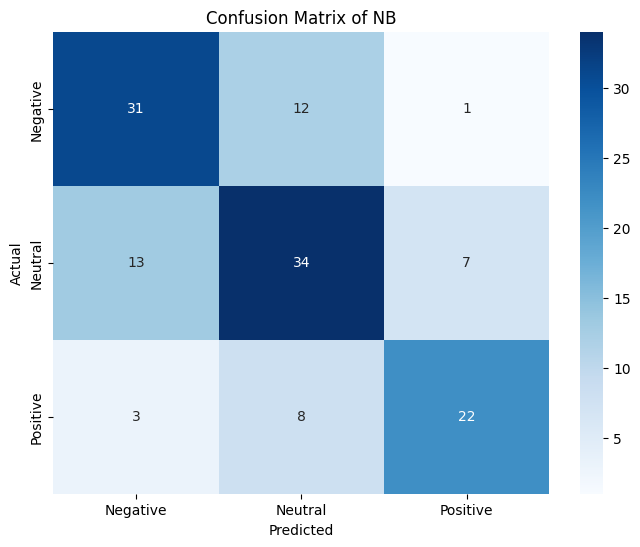

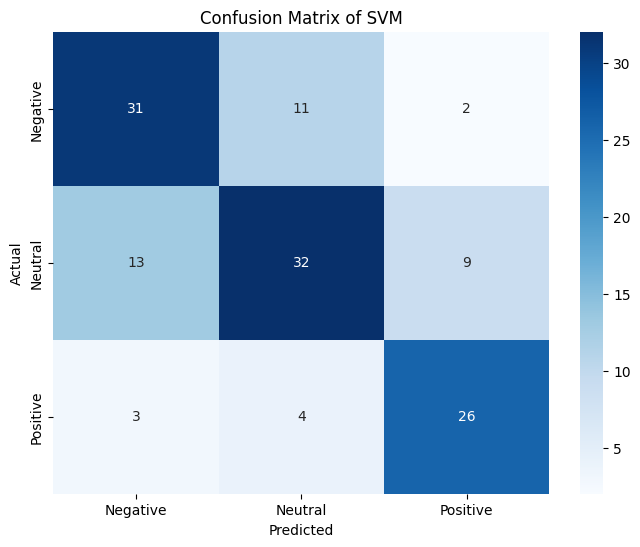

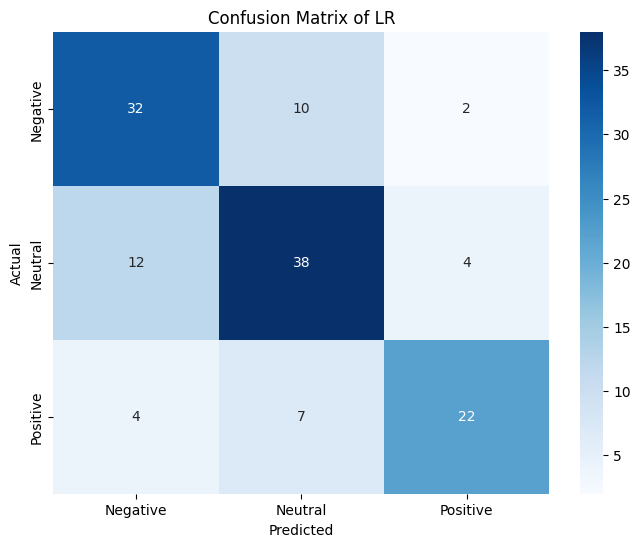

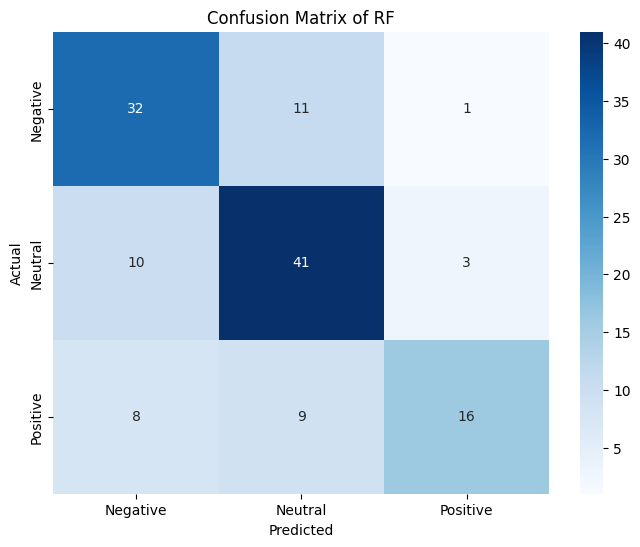

,model,accuracy,precision,recall,f1
0,NB,0.66,0.67,0.66,0.66
1,SVM,0.68,0.68,0.68,0.68
2,LR,0.70,0.71,0.70,0.70
3,RF,0.68,0.69,0.68,0.67


In [ ]:
model_names = ['NB', 'SVM', 'LR', 'RF']
results = []

for model in model_names:
    # Training
    y_pred = training(model)

    # Evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted') # Use 'weighted' for multi-class
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')

    results.append({
        'model': model,
        'accuracy': round(accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'f1': round(f1, 2)
    })

    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=naive_bayes_classifier.classes_,
                yticklabels=naive_bayes_classifier.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix of {model}')
    plt.show()
    print()

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df

In [ ]:
y_pred_lr = logistic_regression_classifier.predict(x_valid)

# Get indices where predictions are wrong
wrong_indices = [i for i in range(len(y_valid)) if y_valid.iloc[i] != y_pred_lr[i]]

# Create a DataFrame of wrong predictions
wrong_predictions_df = pd.DataFrame({
    'Processed_Content': valid_df['processed_content'].iloc[wrong_indices],
    'Label': y_valid.iloc[wrong_indices],
    'Predict': y_pred_lr[wrong_indices]
})

wrong_predictions_df

,Processed_Content,Label,Predict
0,chất_liệu vải màu_sắc đen mô_tả giá rẻ đẹp nha...,Neutral,Positive
5,màu_sắc đen màu đẹp mô_tả form chuẩn_đồ ấm chấ...,Negative,Neutral
8,mô_tả màu_sắc đen trắng chất_liệu vải áo đẹp l...,Positive,Neutral
11,chất_liệu phông dầy_dặn mô_tả mô_tả màu_sắc hì...,Neutral,Positive
16,chất_liệu vãi hơi mỏng mát màu_sắc hình,Negative,Neutral
17,áo mua trên_dưới 10c hàng giá mặc tầm cổ rão đ...,Neutral,Negative
18,mô_tả vải thun cá_sấu ! vải k,Negative,Neutral
22,mô_tả ko ro màu_sắc den chất_liệu nilon chất d...,Negative,Neutral
23,màu_sắc đen chất_liệu nút áo cuốiáo đẹp 5 kiểm...,Negative,Neutral
24,áo rách 1 giá rẻ đấy chất_lượng ko ổn lắm chán...,Neutral,Negative


In [ ]:
C_values = [0.01, 0.1, 1, 10, 100]
comparison = []

for c in C_values:
    logistic_regression = LogisticRegression(C=c)
    logistic_regression.fit(x_train, y_train)
    y_pred = logistic_regression.predict(x_valid)

    # Evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted') # Use 'weighted' for multi-class
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')

    comparison.append({
        'C': c,
        'accuracy': round(accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'f1': round(f1, 2)
    })

# Create a DataFrame from the comparison
comparison_df = pd.DataFrame(comparison)

# Display the comparison DataFrame
comparison_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,C,accuracy,precision,recall,f1
0,0.01,0.41,0.17,0.41,0.24
1,0.10,0.56,0.68,0.56,0.50
2,1.00,0.70,0.71,0.70,0.70
3,10.00,0.66,0.66,0.66,0.66
4,100.00,0.68,0.68,0.68,0.68


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

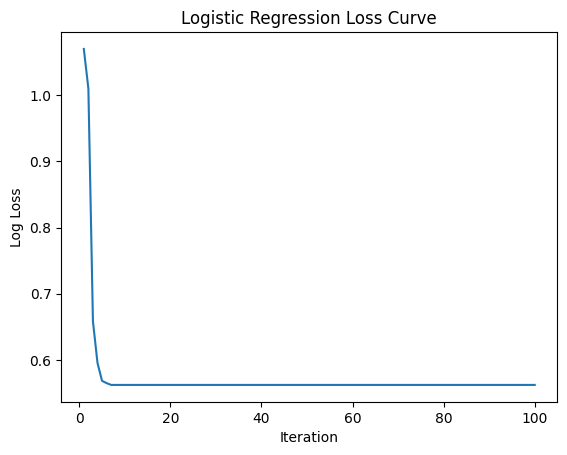

In [ ]:
from sklearn.metrics import log_loss

# Initialize parameters
max_iters = 100
loss_log = []

# Train model iteratively and record loss
model = LogisticRegression(warm_start=True, max_iter=1)

for i in range(1, max_iters + 1):
    model.max_iter = i  # Increase iterations one step at a time
    model.fit(x_train, y_train)  # Train
    y_pred_prob = model.predict_proba(x_train)  # Get predicted probabilities
    loss = log_loss(y_train, y_pred_prob)  # Compute log loss
    loss_log.append(loss)  # Store loss value

# Plot loss curve
plt.plot(range(1, max_iters + 1), loss_log, linestyle="-")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Logistic Regression Loss Curve")
plt.show()

In [ ]:
import joblib

save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/'
# Save the model using joblib
joblib.dump(logistic_regression_classifier, save_path + 'logistic_regression_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/NLP/midterm/logistic_regression_model.joblib']

#Test

In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Retrieve model
save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/'
logistic_regression_classifier = joblib.load(save_path + 'logistic_regression_model.joblib')

# Retrive tfidf vectorizer
train_df_path = '/content/drive/MyDrive/Colab Notebooks/NLP/midterm/train_df.csv'
train_df = pd.read_csv(train_df_path)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer.fit_transform(train_df['processed_content'])

<523x1723 sparse matrix of type '<class 'numpy.float64'>'
	with 9026 stored elements in Compressed Sparse Row format>

In [ ]:
new_comment = 'áo đẹp 👍👍👍'
new_comment_tfidf = tfidf_vectorizer.transform([new_comment])
predicted_sentiment = logistic_regression_classifier.predict(new_comment_tfidf)
print(f"Predicted sentiment: {predicted_sentiment[0]}")

Predicted sentiment: Positive
